In [1]:
!pip install crowd-kit

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from typing import List, Tuple
from crowdkit.aggregation import DawidSkene, MajorityVote

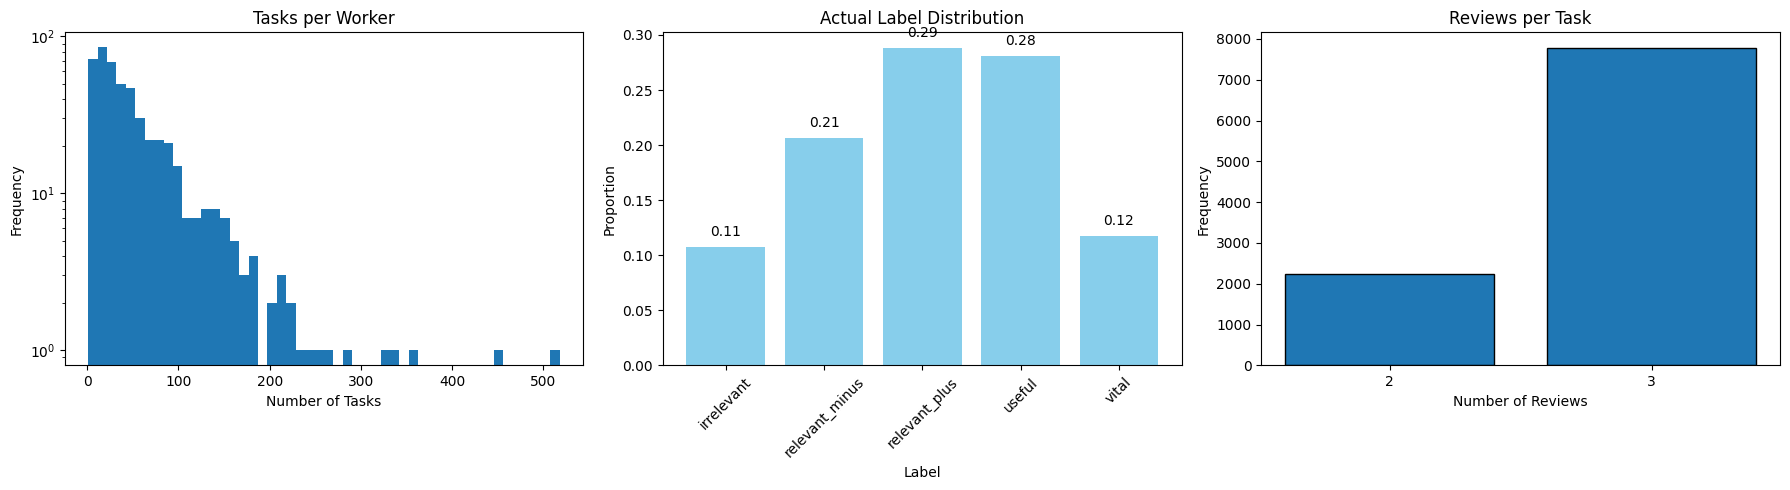

In [3]:
def generate_worker_weights(number_workers: int, mu: float = 1.5, sigma: float = 1.0) -> np.ndarray:
    weights = np.random.lognormal(mu, sigma, number_workers)
    return weights / weights.sum()

def select_workers(weights: np.ndarray, size: int = 2, exclude: List[int] = None) -> np.ndarray:
    if exclude:
        temp_weights = weights.copy()
        temp_weights[exclude] = 0
        temp_weights = temp_weights / temp_weights.sum()
    else:
        temp_weights = weights

    return np.random.choice(len(weights), size=size, replace=False, p=temp_weights)

def adjust_label_by_credibility(label: str, labels: List[str]) -> str:
    current_label_idx = labels.index(label)
    noise_range = max(0, current_label_idx-1), min(len(labels)-1, current_label_idx+1)
    return labels[np.random.randint(noise_range[0], noise_range[1]+1)]

def generate_tasks(
    number_tasks: int,
    number_workers: int,
    labels: List[str],
    label_distribution: List[float],
    worker_credibility: np.ndarray
) -> pd.DataFrame:
    tasks, workers, labels_assigned, third_worker_triggered = [], [], [], []

    worker_weights = generate_worker_weights(number_workers)

    for task_id in range(number_tasks):
        # Select two workers based on log-normal distribution weights
        worker1, worker2 = select_workers(worker_weights, size=2)

        # Generate labels and adjust based on credibility
        label1 = np.random.choice(labels, p=label_distribution)
        label2 = np.random.choice(labels, p=label_distribution)

        label1 = adjust_label_by_credibility(label1, labels) if worker_credibility[worker1] > 0.8 else label1
        label2 = adjust_label_by_credibility(label2, labels) if worker_credibility[worker2] > 0.8 else label2

        # Handle case when labels don't match
        if label1 != label2:
            # Select third worker and generate label
            third_worker = select_workers(worker_weights, size=1, exclude=[worker1, worker2])[0]
            label3 = np.random.choice(labels, p=label_distribution)

            # the third worker
            label3 = adjust_label_by_credibility(label3, labels) if worker_credibility[third_worker] > 0.8 else label3

            tasks.extend([task_id, task_id, task_id])
            workers.extend([worker1, worker2, third_worker])
            labels_assigned.extend([label1, label2, label3])
            third_worker_triggered.extend([False, False, True])
        else:
            # Handle case when labels match
            tasks.extend([task_id, task_id])
            workers.extend([worker1, worker2])
            labels_assigned.extend([label1, label2])
            third_worker_triggered.extend([False, False])

    return pd.DataFrame({
        'task': tasks,
        'worker': workers,
        'label': labels_assigned,
        'third_worker_triggered': third_worker_triggered
    })

def visualize_distributions(data: pd.DataFrame, labels: List[str]) -> None:
    task_count_per_worker = data['worker'].value_counts()
    label_distribution_actual = data['label'].value_counts(normalize=True)
    task_overlap_distribution = data['task'].value_counts()

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Worker task count distribution
    worker_task_counts = data['worker'].value_counts()
    axes[0].hist(worker_task_counts, bins=50)
    axes[0].set_title('Tasks per Worker')
    axes[0].set_xlabel('Number of Tasks')
    axes[0].set_ylabel('Frequency')
    axes[0].set_yscale('log')

    # Label distribution
    label_distribution_ordered = label_distribution_actual.reindex(labels)
    axes[1].bar(range(len(label_distribution_ordered)), label_distribution_ordered.values, color='skyblue')
    axes[1].set_xticks(range(len(label_distribution_ordered)))
    axes[1].set_xticklabels(label_distribution_ordered.index, rotation=45)
    axes[1].set_title('Actual Label Distribution')
    axes[1].set_xlabel('Label')
    axes[1].set_ylabel('Proportion')
    for i, v in enumerate(label_distribution_ordered.values):
        axes[1].text(i, v + 0.01, f"{v:.2f}", ha='center')

    # Distribution of reviews per task
    axes[2].bar(range(2, 4),
                [sum(task_overlap_distribution == i) for i in range(2, 4)],
                edgecolor='black')
    axes[2].set_title('Reviews per Task')
    axes[2].set_xlabel('Number of Reviews')
    axes[2].set_ylabel('Frequency')
    axes[2].set_xticks([2, 3])

    plt.tight_layout()
    plt.show()


np.random.seed(32)

# Parameter settings
number_tasks = 10000
number_workers = 500
labels = ['irrelevant', 'relevant_minus', 'relevant_plus', 'useful', 'vital']
label_distribution = [0.1, 0.2, 0.3, 0.3, 0.1]

# Generate worker credibility
worker_credibility = np.random.rand(number_workers) * 0.5 + 0.5

data = generate_tasks(
    number_tasks,
    number_workers,
    labels,
    label_distribution,
    worker_credibility
)

visualize_distributions(data, labels)

**Analysis of the rationale for the choice of the label distribution**

Reasons for choosing this distribution
1. The quality assessment of search results usually shows a pyramid distribution:

Irrelevant and vital results are fewer (10 per cent each).

Moderately relevant (relevant_plus) and useful (useful) results account for the main part of the results (30 per cent each)

Lower relevance (relevant_minus) results dominate (20%)

This distribution reflects the performance characteristics of actual search engines:

Modern search engines are relatively sophisticated and have fewer completely irrelevant results

the highest quality results are also relatively rare

Most results fall in the medium relevance range

In [4]:
def aggregate_labels(data: pd.DataFrame) -> tuple[pd.Series, pd.Series]:
    mv = MajorityVote()
    ds = DawidSkene()
    mv_result = mv.fit_predict(data)
    ds_result = ds.fit_predict(data)
    return mv_result, ds_result

# analysis
mv_result, ds_result = aggregate_labels(data)
results = pd.DataFrame({
    'task': data['task'].unique(),
    'MajorityVote': mv_result.values,
    'DawidSkene': ds_result.values
}).reset_index(drop=True)


def analyze_cases(data, mv_result, ds_result):
    # Create a DataFrame with all results
    tasks = data['task'].unique()
    results = pd.DataFrame()

    for task in tasks:
        task_labels = data[data['task'] == task]['label'].values
        mv_label = mv_result[task]
        ds_label = ds_result[task]

        # Sort labels
        unique_labels = np.unique(task_labels)
        n_unique = len(unique_labels)
        n_assessors = len(task_labels)

        # Calculate frequencies
        label_counts = pd.Series(task_labels).value_counts()

        # case type
        if n_assessors == 2:
            if n_unique == 1:
                case_type = 1  # Two assessors give the same rating
            else:
                # Cases needing third assessor will be handled when n_assessors == 3
                continue
        else:  # n_assessors == 3
            if n_unique == 1:
                case_type = 1
            elif n_unique == 2:
                # Check if first two assessors disagree
                first_two_assessors = task_labels[:2]
                if len(np.unique(first_two_assessors)) == 2:  # First two assessors disagree
                    third_assessor = task_labels[2]
                    # Check if third assessor agrees with one of the first two
                    if third_assessor in first_two_assessors:
                        case_type = 2  # Third assessor agrees with one of the first two
                    else:
                        continue  # Case doesn't meet requirements
                else:
                    continue  # Case doesn't meet requirements
            else:  # n_unique == 3
                case_type = 3  # All assessors give different ratings

        # Check agreement between MV and DS
        mv_ds_agree = mv_label == ds_label

        # Create case identifier
        final_case = case_type if mv_ds_agree else case_type + 3

        results = pd.concat([results, pd.DataFrame({
            'task': [task],
            'case_type': [case_type],
            'mv_ds_agree': [mv_ds_agree],
            'final_case': [final_case],
            'labels': [', '.join(task_labels)],
            'mv_label': [mv_label],
            'ds_label': [ds_label]
        })])

    return results

mv_labels = pd.Series(mv_result)
ds_labels = pd.Series(ds_result)
case_analysis = analyze_cases(data, mv_labels, ds_labels)

case_frequencies = case_analysis['final_case'].value_counts().sort_index()

# descriptions
case_descriptions = {
    1: "Two assessors give same rating, MV and DS agree",
    2: "Two assessors give different ratings, third assessor agrees with one, MV and DS agree",
    3: "Three assessors give different ratings, MV and DS agree",
    4: "Two assessors give same rating, MV and DS disagree",
    5: "Two assessors give different ratings, third assessor agrees with one, MV and DS disagree",
    6: "Three assessors give different ratings, MV and DS disagree"
}

# final summary DataFrame
summary_df = pd.DataFrame({
    'case': range(1, 7),
    'description': [case_descriptions[i] for i in range(1, 7)],
    'frequency': [case_frequencies.get(i, 0) for i in range(1, 7)],
    'percentage': [case_frequencies.get(i, 0) / len(case_analysis) * 100 for i in range(1, 7)]
})


summary_df

,case,description,frequency,percentage
0,1,"Two assessors give same rating, MV and DS agree",1514,15.14
1,2,"Two assessors give different ratings, third as...",1871,18.71
2,3,"Three assessors give different ratings, MV and...",1273,12.73
3,4,"Two assessors give same rating, MV and DS disa...",714,7.14
4,5,"Two assessors give different ratings, third as...",1589,15.89
5,6,"Three assessors give different ratings, MV and...",3039,30.39


In [5]:
def detailed_algorithm_comparison(data, mv_result, ds_result, worker_credibility):
    disagreement_analysis = []

    unique_tasks = data['task'].unique()

    for task in unique_tasks:
        task_data = data[data['task'] == task]
        task_labels = task_data['label'].values
        task_workers = task_data['worker'].values

        # Get corresponding algorithm results
        mv_label = mv_result[task]
        ds_label = ds_result[task]

        # If the two algorithms give different results
        if mv_label != ds_label:
            # Calculate relative credibility for each worker
            worker_creds = worker_credibility[task_workers]
            label_credibility = {}

            # Aggregate worker credibility by label
            for label, worker, cred in zip(task_labels, task_workers, worker_creds):
                if label not in label_credibility:
                    label_credibility[label] = []
                label_credibility[label].append(cred)

            # Calculate average credibility for each label
            avg_label_credibility = {
                label: np.mean(creds) for label, creds in label_credibility.items()
            }

            disagreement_analysis.append({
                'task': task,
                'mv_label': mv_label,
                'ds_label': ds_label,
                'original_labels': task_labels,
                'worker_credibilities': worker_creds,
                'label_avg_credibility': avg_label_credibility,
                'unique_labels_count': len(set(task_labels))
            })


    print("\nDawidSkene vs MajorityVote Algorithm Difference Analysis:")

    interesting_cases = sorted(
        disagreement_analysis,
        key=lambda x: max(x['label_avg_credibility'].values()) -
                      min(x['label_avg_credibility'].values()),
        reverse=True
    )[:5]

    print("\nTop 5 Representative Difference Cases:")
    for case in interesting_cases:
        print(f"\nTask ID: {case['task']}")
        print(f"MajorityVote Label: {case['mv_label']}")
        print(f"DawidSkene Label: {case['ds_label']}")
        print(f"Original Labels: {case['original_labels']}")
        print("Average Label Credibility:")
        for label, cred in case['label_avg_credibility'].items():
            print(f"  {label}: {cred:.4f}")

detailed_algorithm_comparison(data, mv_result, ds_result, worker_credibility)


DawidSkene vs MajorityVote Algorithm Difference Analysis:

Top 5 Representative Difference Cases:

Task ID: 2774
MajorityVote Label: irrelevant
DawidSkene Label: vital
Original Labels: ['irrelevant' 'vital' 'useful']
Average Label Credibility:
  irrelevant: 0.9997
  vital: 0.5028
  useful: 0.6304

Task ID: 7124
MajorityVote Label: irrelevant
DawidSkene Label: relevant_plus
Original Labels: ['irrelevant' 'vital' 'useful']
Average Label Credibility:
  irrelevant: 0.5035
  vital: 0.9964
  useful: 0.8443

Task ID: 4842
MajorityVote Label: irrelevant
DawidSkene Label: vital
Original Labels: ['irrelevant' 'relevant_plus' 'vital']
Average Label Credibility:
  irrelevant: 0.8279
  relevant_plus: 0.9932
  vital: 0.5034

Task ID: 2662
MajorityVote Label: irrelevant
DawidSkene Label: useful
Original Labels: ['irrelevant' 'useful' 'relevant_minus']
Average Label Credibility:
  irrelevant: 0.5035
  useful: 0.7836
  relevant_minus: 0.9932

Task ID: 8356
MajorityVote Label: relevant_minus
DawidSkene

**Key features of the Dawid-Skene algorithm:**
- dynamically estimates the reliability of each worker
- looks not only at the majority vote, but also considers the historical accuracy of the worker
- adjusts worker reliability and true label estimates through an iterative approach

**Why minority opinion is chosen:**
- Minority workers have historically performed more accurately
- When majority vote may be affected by systematic bias
- Adjusting label likelihood based on Bayesian inference